# HW12

### Author: Joseph Wong

## Import Packages

In [87]:
# Some basic package imports
import os
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.defaule = 'colab'
import seaborn as sns

# ML packages
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## About the Data

### Import the Data

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amldvvs/avocado-ripeness-classification-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.64k/3.64k [00:00<00:00, 1.43MB/s]

Extracting files...
Path to dataset files: C:\Users\josee\.cache\kagglehub\datasets\amldvvs\avocado-ripeness-classification-dataset\versions\1


In [4]:
os.listdir(path)

['avocado_ripeness_dataset.csv']

In [8]:
file = path+'\\avocado_ripeness_dataset.csv'
df = pd.read_csv(file)
df.head()

,firmness,hue,saturation,brightness,color_category,sound_db,weight_g,size_cm3,ripeness
0,14.5,19,40,26,black,34,175,261,ripe
1,71.7,53,69,75,green,69,206,185,pre-conditioned
2,88.5,60,94,46,dark green,79,220,143,hard
3,93.8,105,87,41,dark green,75,299,140,hard
4,42.5,303,58,32,purple,63,200,227,breaking


### Data Source

The dataset is owned by Amal Dev and was posted to kaggle.com (*https://www.kaggle.com/datasets/amldvvs/avocado-ripeness-classification-dataset*). The data was last updated in May 2025 and I accessed the data on October 21, 2025. There is an Apache 2.0 license, which means the dataset is permissive and open-source (*https://www.apache.org/licenses/LICENSE-2.0*). It is a synthetic dataset based on data from the USDA Agricultural Handbook No. 66 (Commercial Storage of Fruits, Vegetables, and Florist and Nursery Stocks), Hass Avocado Board Ripening Guidelines (2023 Postharvest Best Practices), and peer-reviewed studies on avocado quality assessment (Journal of Food Science (2021): Acoustic firmness testing, Postharvest Biology and Technology (2022): HSB color progression).

### Variables

In [23]:
df.dtypes

firmness          float64
hue                 int64
saturation          int64
brightness          int64
color_category     object
sound_db            int64
weight_g            int64
size_cm3            int64
ripeness           object
dtype: object

The datatypes for each column appears to be reasonable.

**Variables:**
- 'firmness': resistance to penetration
    - measurement method: penetrometer
    - unit & range: 10-100 N
- 'hue': color wavelength
    - measurement method: camera & HSB conversion
    - unit & range: 0-360°
- 'saturation': color intensity
    - measurement method: camera & HSB conversion
    - unit & range: 0-100%
- 'brightness': color lightness
    - measurement method: camera & HSB conversion
    - unit & range: 0-100%
- 'sound_db': acoustic response
    - measurement method: microphone (tapping test)
    - unit & range: 30-80 dB
- 'weight_g': fruit mass
    - measurement method: digital scale
    - unit & range: 150-300 g
- 'size_cm3': volume measurement
    - measurement method: calipers
    - unit & range: 100-300 cm³

**'ripeness' and 'color_category' are potential target columns, which means they may contain the data we want to predict.** Ripeness is the maturation stage, which is either hard, pre-conditioned, breaking, firm-ripe, or ripe. Color category is the visual skin color, which is either dark green, green, purple, or black.

## Basic Analysis

### Basics

In [13]:
df.shape

(250, 9)

There are 250 observations and 9 variables.

In [14]:
df.describe()

,firmness,hue,saturation,brightness,sound_db,weight_g,size_cm3
count,250.000000,250.00000,250.000000,250.00000,250.000000,250.000000,250.000000
mean,50.618400,125.94400,64.356000,45.07200,58.016000,220.188000,208.644000
std,27.277678,117.13767,17.377144,19.11629,13.838126,34.405225,55.940564
min,10.300000,1.00000,30.000000,10.00000,30.000000,152.000000,100.000000
25%,25.750000,25.25000,51.250000,31.00000,47.250000,193.250000,155.250000
50%,48.950000,77.00000,65.000000,46.00000,60.000000,220.000000,218.000000
75%,74.050000,278.75000,76.750000,58.00000,68.000000,245.000000,260.500000
max,98.800000,329.00000,99.000000,78.00000,79.000000,299.000000,299.000000


In [17]:
df['color_category'].value_counts()

color_category
black         75
purple        75
green         50
dark green    50
Name: count, dtype: int64

In [18]:
df['ripeness'].value_counts()

ripeness
ripe               50
pre-conditioned    50
hard               50
breaking           50
firm-ripe          50
Name: count, dtype: int64

There does not appear to be any NaNs in any column.

By looking at the statistics/distributions of each variable, it appears that there are no outliers in the dataset.

There are 50 observations of each 'ripeness' category and each 'color_category' category has either 50 or 75 observations. This means the data is well-balanced.

### Pairplots

#### Ripeness

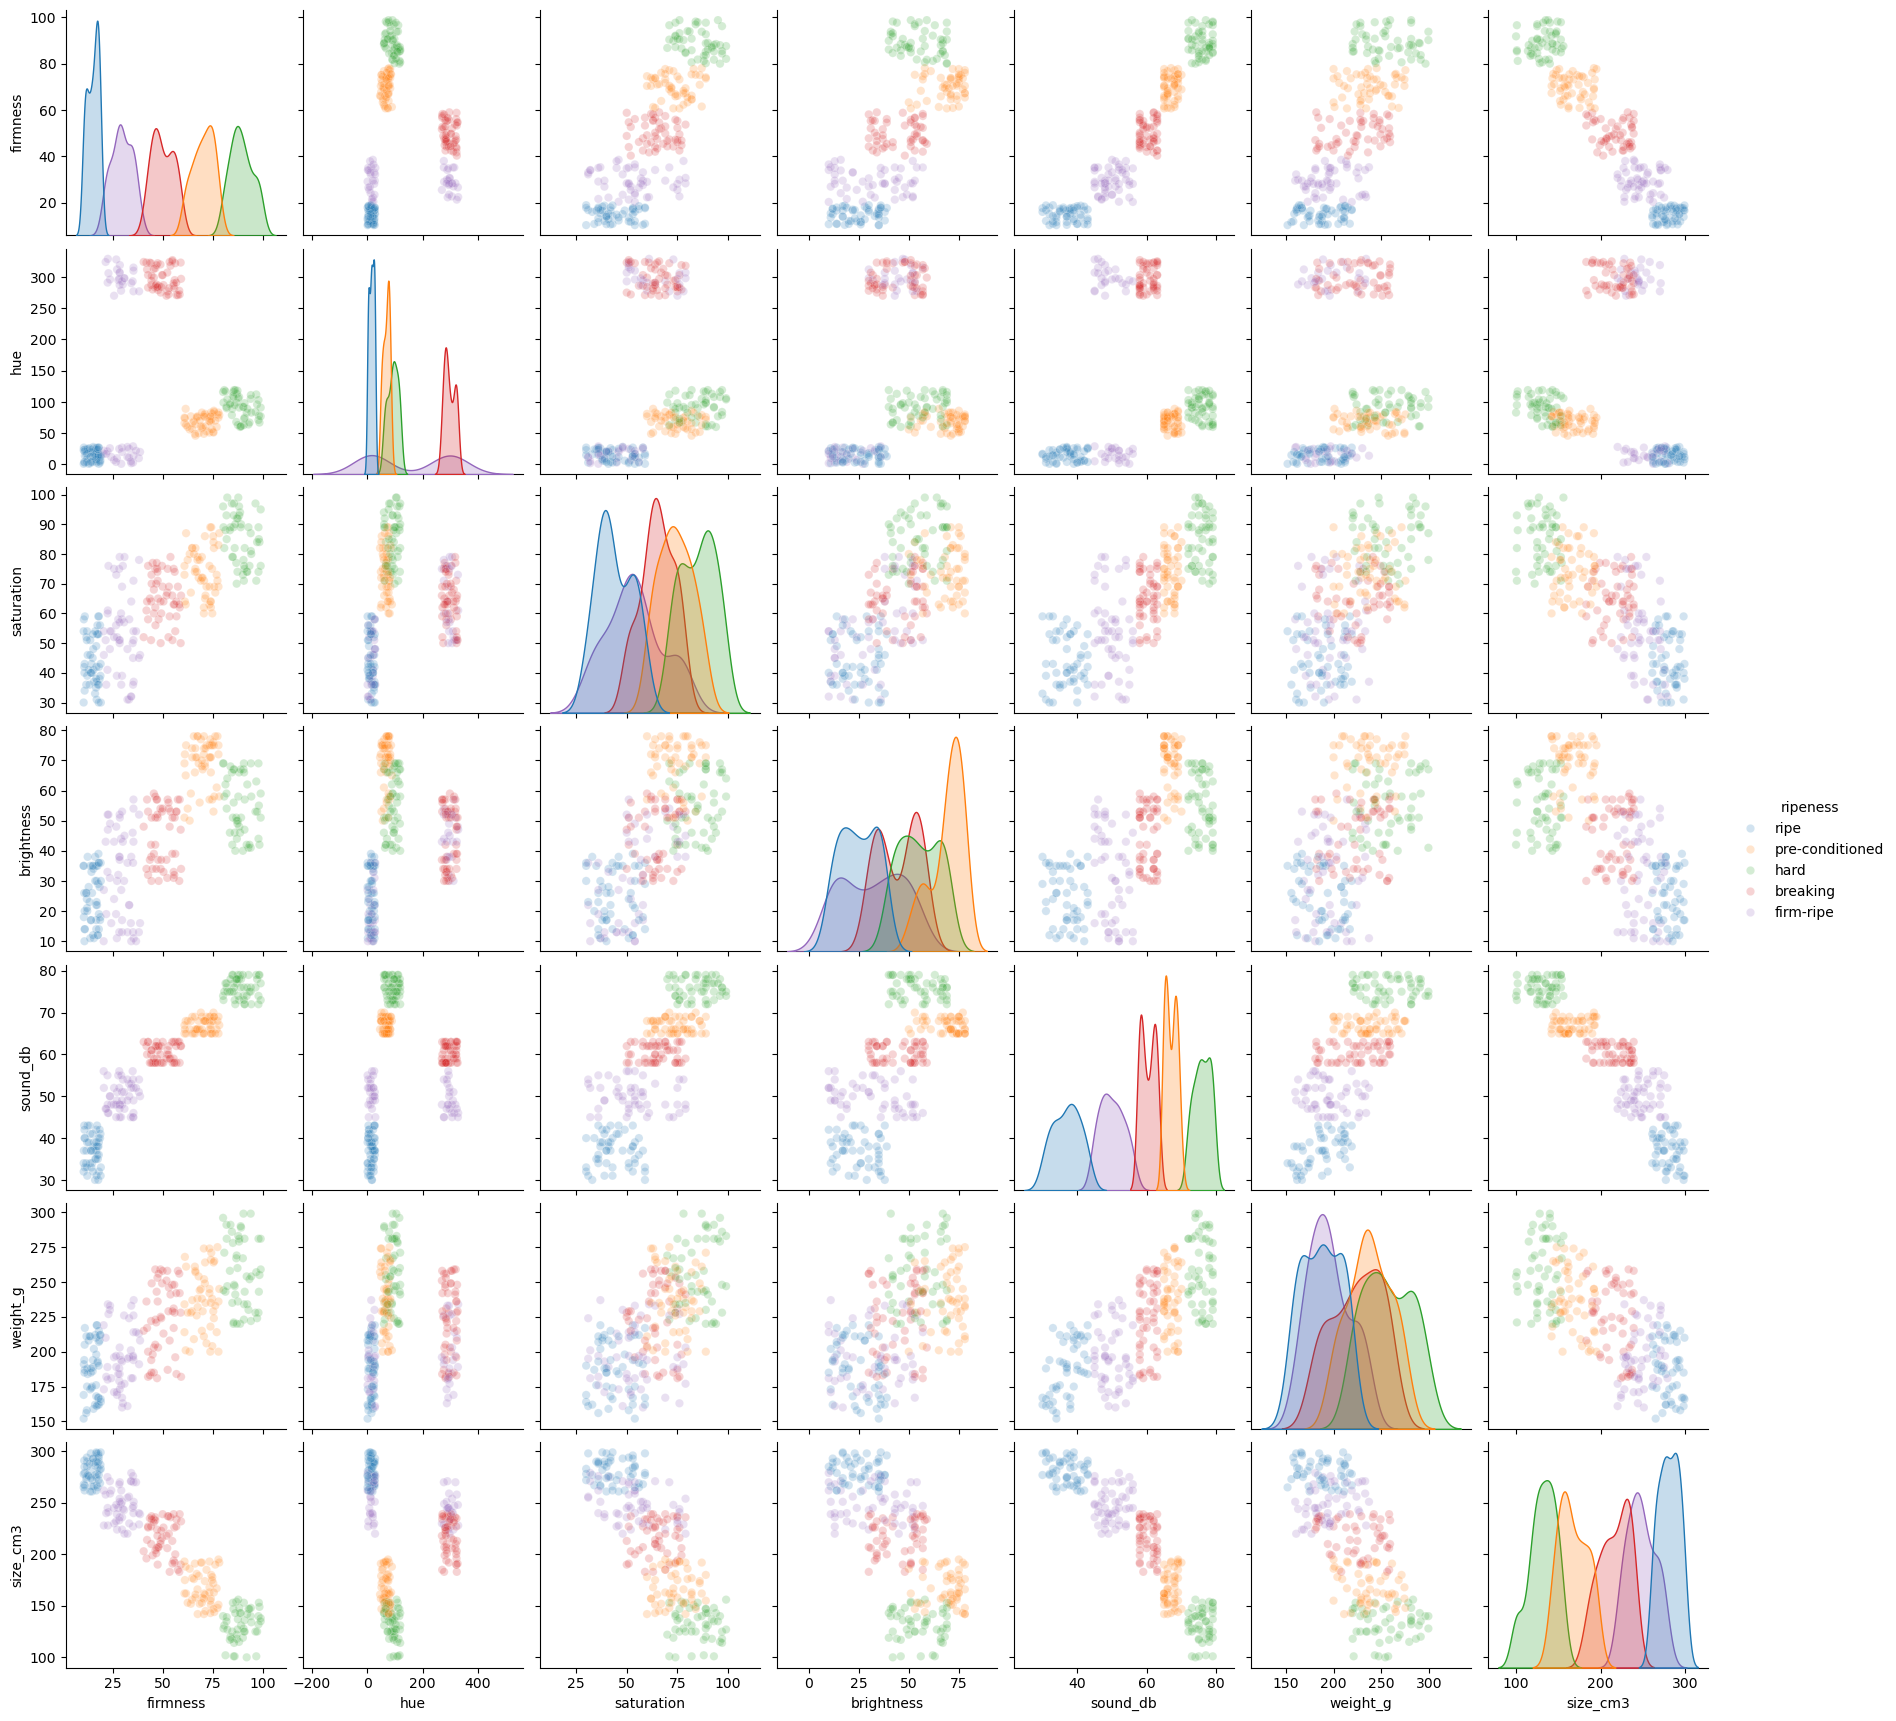

In [21]:
sns.pairplot(df, diag_kind="kde", plot_kws={"alpha": 0.2}, hue='ripeness')
plt.show()

#### Color Category

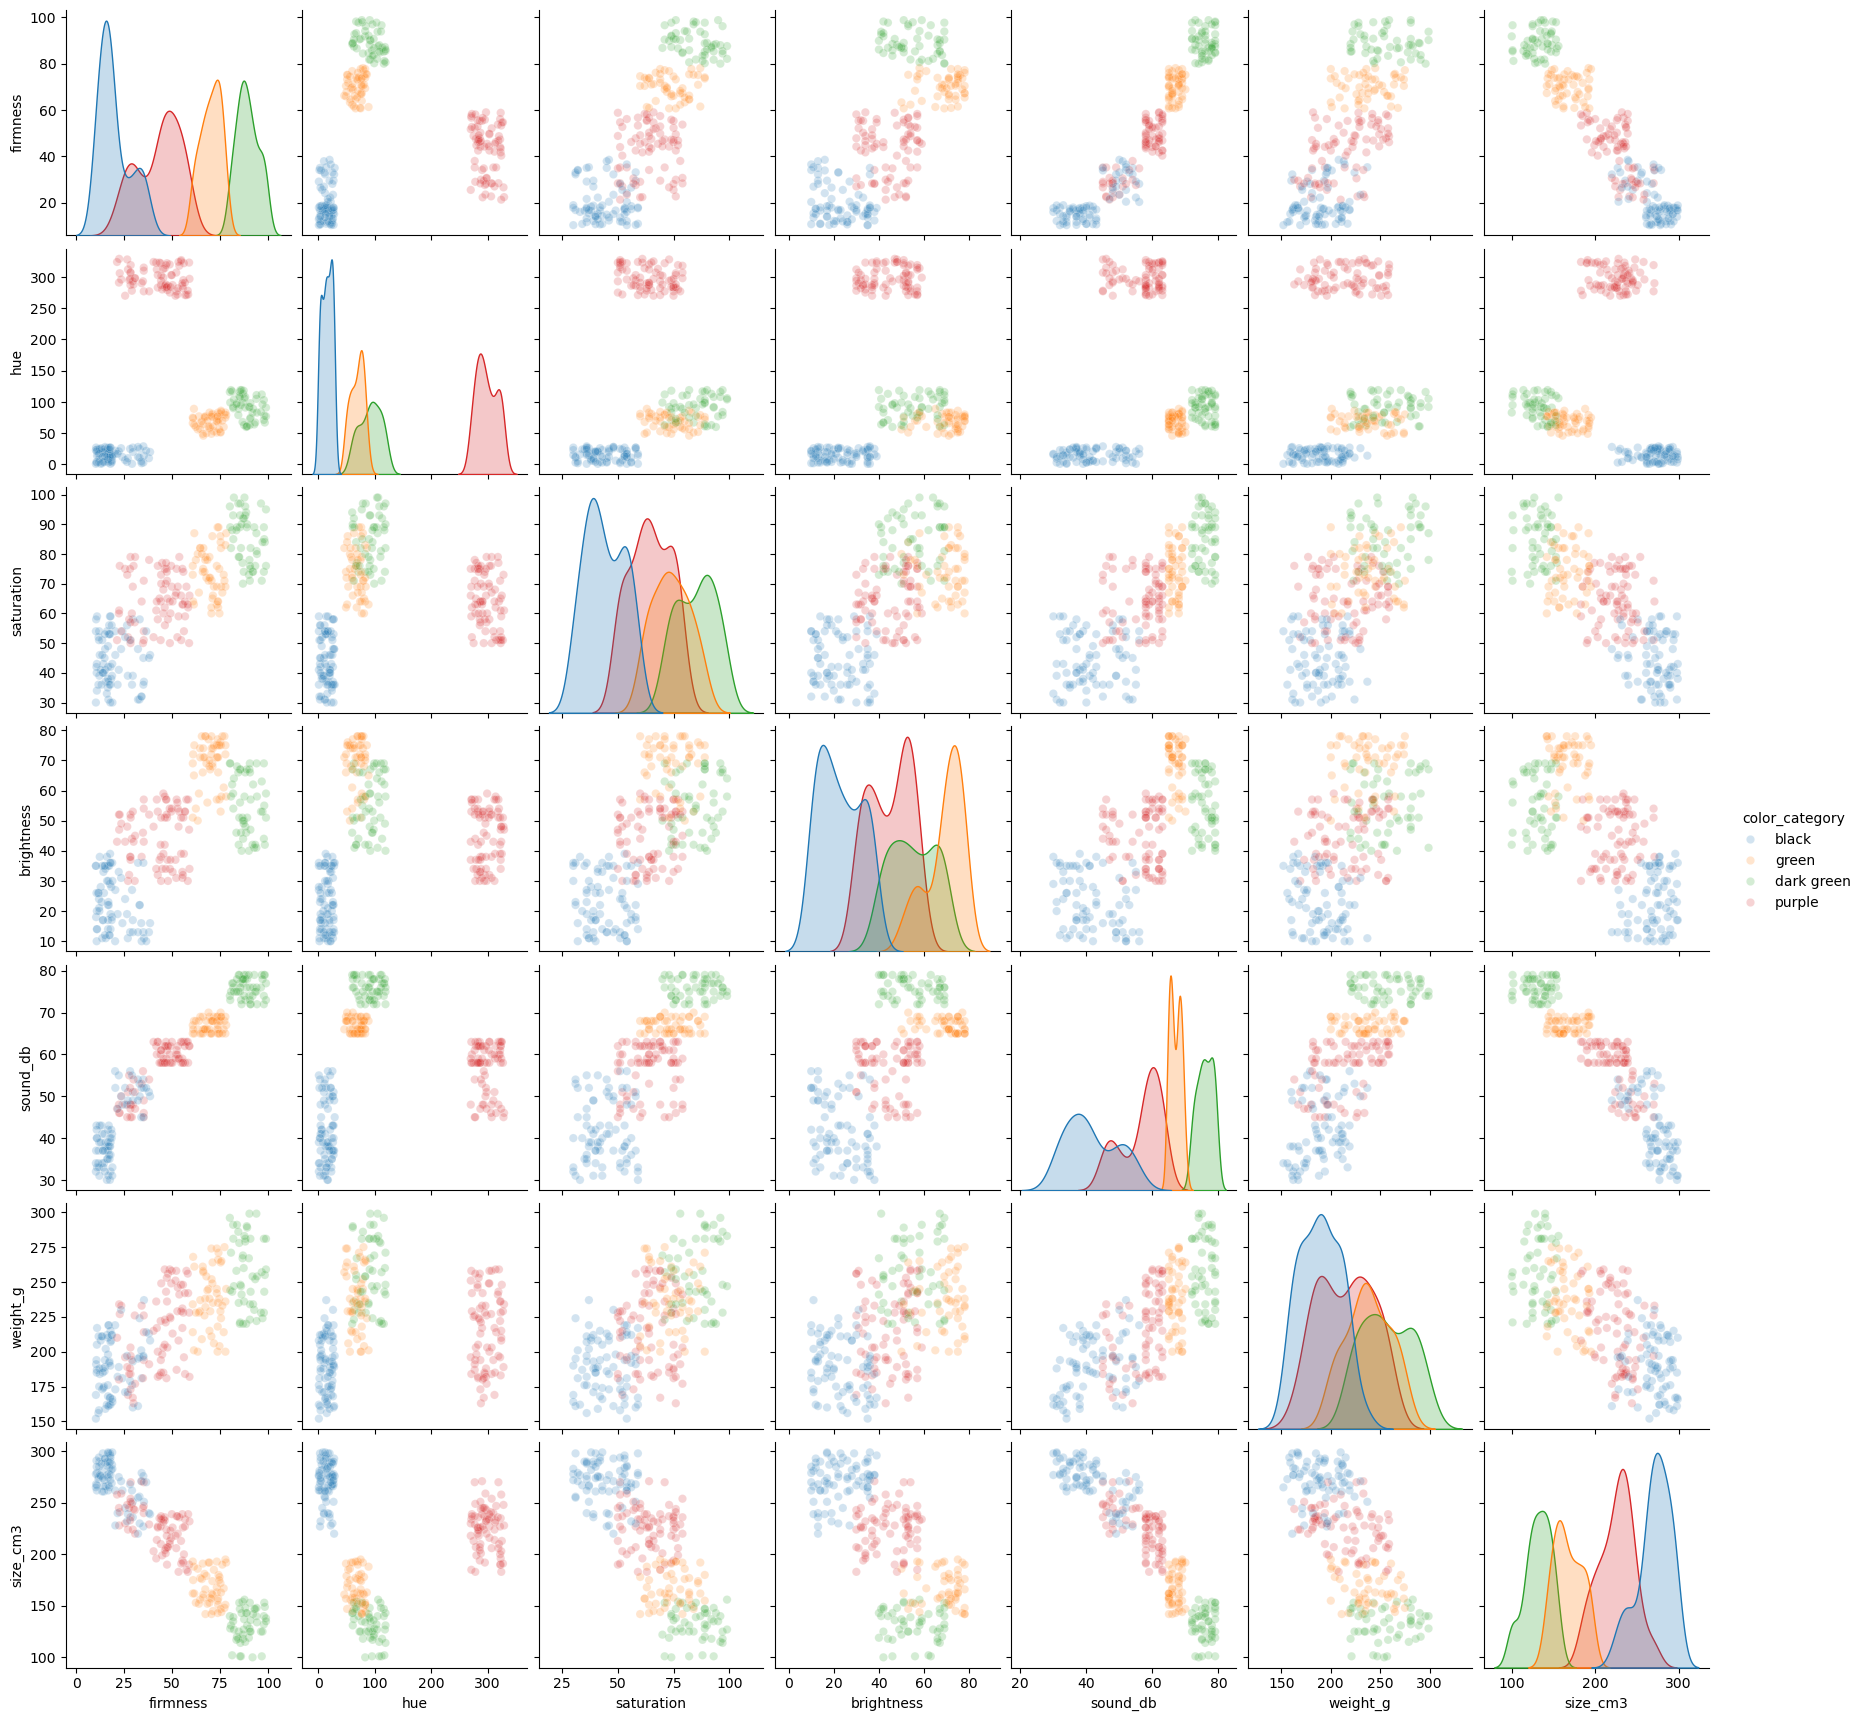

In [22]:
sns.pairplot(df, diag_kind="kde", plot_kws={"alpha": 0.2}, hue='color_category')
plt.show()

#### Analysis

To identify good individual predictors for classification, we will look for variables whose distributions have clusters of categories with little to no overlap. For ripeness, this could potentially be 'firmness' or acoustic response ('sound_db'). For color category, the distributions of individual variables tend to have a significant amount of overlap for the categories. So, it seems easier to classify ripeness based on just one variable.

In general, the distributions for two variable combinations tend to be stratified by ripeness category. One exception to this is weight, as its distributions have less distinct clustering. Firmness and acoustic response together appear to have the least overlap, which suggests they may produce accurate predictions.

The same is somewhat true for stratification by color category, but the clusters tend to have more overlap with one another. This may make it more difficult to get an accurate prediction.

Therefore, ripeness seems to have more distinct clusters based on variables in the dataset. So, we will build a model to predict ripeness.

## Build the Model

### Test-Train Split

In [80]:
data_cols = ['firmness', 'hue', 'saturation', 'brightness', 'sound_db', 'weight_g', 'size_cm3']
target_cols = ['ripeness']

random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(df[data_cols],
                                                    df[target_cols], 
                                                    test_size=0.20, 
                                                    random_state=random_seed)

y_test = y_test.to_numpy().reshape(-1)
y_train = y_train.to_numpy().reshape(-1)

### Train a KNN Model

In [89]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### Test Model Accuracy

In [90]:
y_pred = knn.predict(X_test)

In [91]:
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

Test set score: 1.00


I trained the KNN model using 3 neighbors and got an accuracy of 0.92.

## Tune the Model

### How many neighbors gives the best results?

In [58]:
n_acc = []
for n in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = knn.score(X_test, y_test)
    n_acc.append({'n_neighbors':n, 'accuracy':accuracy})
df_n_acc = pd.DataFrame(n_acc)
df_n_acc

,n_neighbors,accuracy
0,1,0.92
1,2,0.94
2,3,0.92
3,4,0.92
4,5,0.94
5,6,0.96
6,7,0.94
7,8,0.94
8,9,0.90
9,10,0.90


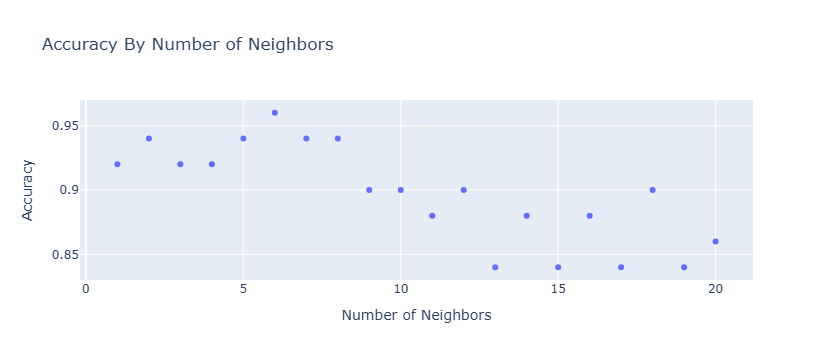

In [59]:
fig = px.scatter(df_n_acc,
                 x='n_neighbors',
                 y='accuracy',
                 title="Accuracy By Number of Neighbors")
fig.update_layout(xaxis_title="Number of Neighbors",
                  yaxis_title="Accuracy")
fig.show()

The graph suggests that as the number of neighbors increases, the accuracy tends to decrease. Using less than 9 neighbors produces accuracies over 0.9.

In [60]:
df_n_acc.loc[df_n_acc['accuracy'] == df_n_acc['accuracy'].max()]

,n_neighbors,accuracy
5,6,0.96


Using 6 neighbors produces the highest prediction accuracy, which is 0.96.

In [62]:
df_n_acc.loc[df_n_acc['accuracy'] == df_n_acc['accuracy'].min()]

,n_neighbors,accuracy
12,13,0.84
14,15,0.84
16,17,0.84
18,19,0.84


Using 13, 15, 17, or 19 neighbors produces the lowest prediction accuracy, which is 0.84.

### How many features are necessary to get a good prediction?

#### Firmness and Acoustic Response

In [126]:
data_cols = ['firmness', 'sound_db']
target_cols = ['ripeness']

random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(df[data_cols],
                                                    df[target_cols], 
                                                    test_size=0.20, 
                                                    random_state=random_seed)

y_test = y_test.to_numpy().reshape(-1)
y_train = y_train.to_numpy().reshape(-1)

In [127]:
n_acc = []
for n in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = knn.score(X_test, y_test)
    n_acc.append({'n_neighbors':n, 'accuracy':accuracy})
df_n_acc_firm_sound = pd.DataFrame(n_acc)
df_n_acc_firm_sound['accuracy'].value_counts()

accuracy
1.0    20
Name: count, dtype: int64

#### Firmness

In [128]:
data_cols = ['firmness']
target_cols = ['ripeness']

random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(df[data_cols],
                                                    df[target_cols], 
                                                    test_size=0.20, 
                                                    random_state=random_seed)

y_test = y_test.to_numpy().reshape(-1)
y_train = y_train.to_numpy().reshape(-1)

In [129]:
n_acc = []
for n in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = knn.score(X_test, y_test)
    n_acc.append({'n_neighbors':n, 'accuracy':accuracy})
df_n_acc_firm = pd.DataFrame(n_acc)
df_n_acc_firm['accuracy'].value_counts()

accuracy
1.00    18
0.98     2
Name: count, dtype: int64

#### Acoustic Response

In [130]:
data_cols = ['sound_db']
target_cols = ['ripeness']

random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(df[data_cols],
                                                    df[target_cols], 
                                                    test_size=0.20, 
                                                    random_state=random_seed)

y_test = y_test.to_numpy().reshape(-1)
y_train = y_train.to_numpy().reshape(-1)

In [131]:
n_acc = []
for n in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = knn.score(X_test, y_test)
    n_acc.append({'n_neighbors':n, 'accuracy':accuracy})
df_n_acc_sound = pd.DataFrame(n_acc)
df_n_acc_sound['accuracy'].value_counts()

accuracy
1.0    20
Name: count, dtype: int64

#### Analysis

My intial prediction was correct: using firmness individually, acoustic response individually, and both together predicts ripeness very accurately. In fact, their accuracy is 1 for any number of neighbors 1-20, except firmness individually which has an accuracy of 0.98 for two number of neighbors.

## Conclusion

When predicting ripeness, we must consider which features we take into account. Selecting features that have more distinct clustering helps make our predictive models more accurate. Notably, using firmness, acoustic response, or both together as the predictive features produced very accurate predictions. Selecting a good number of neighbors is crucial to optimizing accuracy. Selecting too many neighbors may cause farther observations to have too great of an influence on the prediction. Selecting too few neighbors can also cause issues if there are multiple clusters in the same area. In conclusion, it is crucial to fine tune machine learning predictive models to optimize for accuracy.